# TABLE:

**Libraries and Initializations**
> - Import necessary libararies
> - Path initialization of dataset input

**Text processing**
> - Parse token.txt file formatted as **[img.jpg#d token_text]**.
> - Parsing dictionary **{ img : [caption1, caption2, caption3, caption4, caption5] }**
> - Preprocess captions

**Vocabulary setup**
> - Create word vocabulary

**Train/Test Images**
> - Collect train/test images
> - Process training images: [ captions ] 

**Models** 
> - Initialize ResNet50 model
> - Collect feature_vectors for train/test images

**Embeddings**
> - Initialize glove-embeddings/glove.6B.50d.txt
> - Create Embedding matrix for vocab

**Models updation**
> - Initialize hierarchichal model for image and text training
> - Create custom data generator

**Training/Testing**
> - Train model with image and captions
> - Model testing

# Libraries and Dataset Initialization

## Using Flikr8K dataset
https://www.kaggle.com/datasets/rahul2332/flikr8k

- Contains 8k+ images.

- Also contains 5 captions to each of corresponding images.
- Featured with splitted test and train images set.
- Contains processed captions to avoid memory error and excess vocab size.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import re
import keras
from time import time

from keras.layers import add, Dense, Input, Dropout, Embedding, LSTM
from keras.models import Model, load_model
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords

In [2]:
token_txt_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr8k.token.txt'
train_img_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt'
test_img_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt'

images_path = '/kaggle/input/flikr8k/Flickr8K/Flicker8k_Images/'

# Text Processing

- Parsing token.txt by separting img.jpg and its corresponding caption.

- Allocating all captions to corresponding image in img_descriptions dictionary.
- Cleaning captions

In [3]:
# Reading token.txt 
def ReadTextFile(file):
    with open(file) as f:
        captions = f.read()
    return captions

captions = ReadTextFile(token_txt_path)
captions = captions.split('\n')[:-1]

print(len(captions))
print(captions[0:2])

40460
['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .']


In [4]:
# img_descriptions[img_name] = [ caption1, caption2, caption3, caption4, caption5 ]

img_descriptions = {}

def imageWithText(captions):
    for d in captions:
        image_name, caption = d.split('\t')
        image_name = image_name.split('.')[0]
        
        if img_descriptions.get(image_name) is None:
            img_descriptions[image_name] = []
        
        img_descriptions[image_name].append(caption)
            
imageWithText(captions)

print(len(img_descriptions))

8092


## Visualization of training image and its captions

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


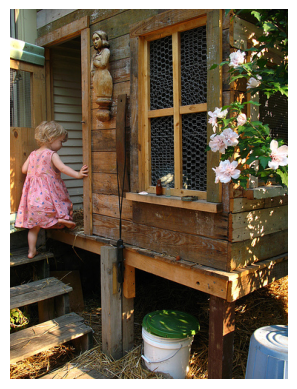

In [5]:
# visualization of captions for single image

print(img_descriptions['1000268201_693b08cb0e'])
img = images_path + '1000268201_693b08cb0e.jpg'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# checking if any of the image in token.txt images is not existing in 8k_images

extra_img = []
for t in img_descriptions.keys():
    p = os.path.join(images_path, t + '.jpg')
    if not os.path.isfile(p):
        extra_img.append(t)

# deleted extra image not found in train images set.
for t in extra_img:
    del(img_descriptions[t])

## Cleaning captions

### Some of questions arises here...

> - Should we lemmatize it ?

> - Should we apply stemming it to limit vocab size ?

> - Should we remove stopwords ?

### No, we can't apply all these because...

> - We need to keep our generated captions grammatically correct and much meaningful.

> - Stemming would generate breakable captions and irrelevant.

> - Stopwords removal can cause incorrect caption generation.

In [7]:
# clean all captions for each of images in img_descriptions

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+', " ", sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

# clean_text("A cat is sitting in room no hello64")

for k, caption_list in img_descriptions.items():
    for c in range(len(caption_list)):
        caption_list[c] = clean_text(caption_list[c])
        
print(img_descriptions['1000268201_693b08cb0e'])

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [8]:
# saving processed captions and [img]

with open('/kaggle/working/descriptions.txt', 'w') as f:
    f.write(str(img_descriptions))

In [9]:
descriptions = {}

with open('/kaggle/working/descriptions.txt', 'r') as f:
    descriptions = f.read()

img_descriptions = json.loads(descriptions.replace("'", "\""))

# Vocabulary setup

In [10]:
# vocab consists of total unique words in captions

vocab = set()
for k in img_descriptions.keys():
    [vocab.update(sentence.split()) for sentence in img_descriptions[k]]
    
print(len(vocab))

8424


In [11]:
# Total_words:List consists of total words in captions repeatedly.

Total_words = []
for k in img_descriptions.keys():
    [Total_words.append(i) for sentence in img_descriptions[k] for i in sentence.split()]
    
print(len(Total_words))

373803


In [12]:
import collections

counter = collections.Counter(Total_words)
freq_count = dict(counter)
print(len(freq_count))

8424


In [13]:
# Neglecting those words which had come even less than 10 times from vocab.

sorted_freq_cnt = sorted(freq_count.items(), reverse=True, key=lambda x: x[1])

threshold = 10  # our threshold_frequency for ignoring word 

sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
Total_words = [x[0] for x in sorted_freq_cnt]

In [14]:
# Our vocab size is now decreased from 8424 to 1845

len(Total_words)

1845

# Train/Test Images

> - 6k train images

> - 1k test images

In [15]:
# Parsing train / test .txt files using user defined function ReadTextFile

train_file_data = ReadTextFile(train_img_path)
test_file_data = ReadTextFile(test_img_path)

train = [r.split('.')[0] for r in train_file_data.split("\n")[:-1]]
test = [r.split('.')[0] for r in test_file_data.split("\n")[:-1]]

print("Train images [] : ", len(train))
print("Test images [] : ", len(test))
print("Train images: ", train[:10])
print("Test images: ", test[:10])

Train images [] :  6000
Test images [] :  1000
Train images:  ['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
Test images:  ['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [16]:
demo_img = '2513260012_03d33305cf'

# Processing captions before training

* We must define start and ending word to each caption for each image.
* These words are necessary for model to predict the end of generated captions.
* Start word is required to initialize the caption on behalf of whole caption can be generated. 

- We will include these two words in our vocab because later these words will be utilised with Embeddings.

In [17]:
# will add start word: startseq and ending word: endseq

train_descriptions = {}
for t in train:
    train_descriptions[t] = []
    for sent in img_descriptions[t]:
        sent = 'startseq ' + sent + ' endseq'
        train_descriptions[t].append(sent)
    
Total_words.append('startseq')
Total_words.append('endseq')
print(train_descriptions['2513260012_03d33305cf'])
vocab_size = len(Total_words) + 1
print(vocab_size)

['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq']
1848


# Model

### Using ResNet50 model from keras with input image shape=(224, 224, 3)

* ResNet50 model predict class from **1000** classes for an image.

* Because we are required only featured vector for all image,

* We will update our model.output to achieve that feature vector of **shape=(2048,)**.

In [18]:
%%capture

model = ResNet50(weights='imagenet', input_shape=(224,224,3))
model.summary()

In [19]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [20]:
%%capture

model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

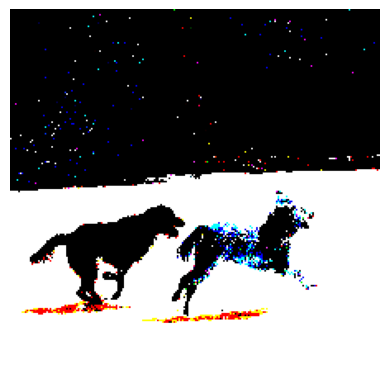

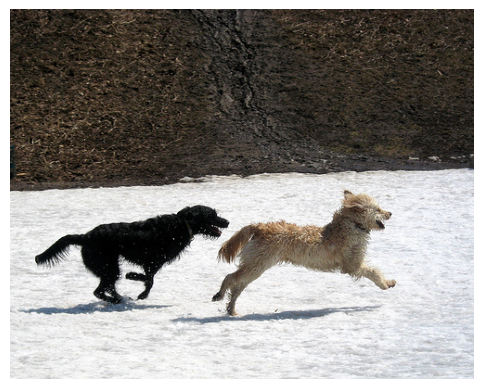

In [21]:
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    img = preprocess_input(img)
    return img


# processed image via resnet50.preprocess_input

img = preprocess_img(images_path + '2513260012_03d33305cf.jpg')
plt.imshow(img[0])
plt.axis('off')
plt.show()
img = plt.imread(images_path + '2513260012_03d33305cf.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
# this function will return featured vector for all images of shape=(2048,)

def encode_images(img_path):
    img = preprocess_img(img_path)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1, ))
    return feature_vector
    
feature_vec = encode_images(images_path + '2513260012_03d33305cf.jpg')
print(feature_vec.shape)


def encoding_data(data):
    start = time()
    encoding_train = {}

    for i, img_id in enumerate(data):
        encoding_train[img_id] = encode_images(images_path + img_id + '.jpg')
        if i%100 == 0:
            print('Encoding in progress %d step'%i)

    end_t = time()
    print("Total time taken: ",end_t - start)
    return encoding_train

1/1 [==============================] - 1s 1s/step
(2048,)


### Obtain feature_vector for all training and test images

> - 6000 training images
> - 1000 test images

- it will be really time taking process and requires GPU for computation.

- [23534592] trainable_parameters will require 6000 * (224, 224, 3) * trainable_parameters + 1000 * (224, 224, 3) * trainable_parameters

_
_
_


> - I have computed those featured_vectors on google colab using T4 GPU runtime, and saved as encoded_features in the INPUT, will use that instead running it here again.

In [23]:
# train with resnet50 for all training images and obtain vector(2048,)

# encoding_train = encoding_data(train)
# encoding_test = encoding_data(test)

# with open('encoded_train_features.pkl', 'wb') as f:
#     pickle.dump(encoding_train, f)

# with open('encoded_test_features.pkl', 'wb') as f:
#     pickle.dump(encoding_test, f)

In [24]:
encoded_test_path = '/kaggle/input/encoded-features/encoded_features/encoded_test_features.pkl'
encoded_train_path = '/kaggle/input/encoded-features/encoded_features/encoded_train_features.pkl'

encoding_train, encoding_test = None, None

with open(encoded_train_path, 'rb') as f:
    encoding_train = pickle.load(f)
    

with open(encoded_test_path, 'rb') as f:
    encoding_test = pickle.load(f)
    

### vocab_words to numbers mapping and vice versa

In [25]:
word_2_idx = {}
idx_2_word = {}

for i, word in enumerate(Total_words):
    word_2_idx[word] = i + 1
    idx_2_word[i + 1] = word

print(word_2_idx['dog'])
print(idx_2_word[6])
print(idx_2_word[1846])
print(idx_2_word[1847])
print(word_2_idx['startseq'])

6
dog
startseq
endseq
1846


In [26]:
# Here we are storing maximum length of single tokenized caption

max_len = 0
for values in train_descriptions.values():
    for sent in values:
        max_len = max(max_len, len(sent.split()))
print(max_len)

35


# **Word Embeddings**

https://www.kaggle.com/datasets/watts2/glove6b50dtxt
- glove is an unsupervised learning algorithm for obtaining vector representations for words


In [27]:
# Parsing glove.txt file
f = open('/kaggle/input/glove-embeddings/glove.6B.50d.txt')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embedding  
    
f.close()    
print(embedding_index['dog'])

[ 0.11008   -0.38781   -0.57615   -0.27714    0.70521    0.53994
 -1.0786    -0.40146    1.1504    -0.5678     0.0038977  0.52878
  0.64561    0.47262    0.48549   -0.18407    0.1801     0.91397
 -1.1979    -0.5778    -0.37985    0.33606    0.772      0.75555
  0.45506   -1.7671    -1.0503     0.42566    0.41893   -0.68327
  1.5673     0.27685   -0.61708    0.64638   -0.076996   0.37118
  0.1308    -0.45137    0.25398   -0.74392   -0.086199   0.24068
 -0.64819    0.83549    1.2502    -0.51379    0.04224   -0.88118
  0.7158     0.38519  ]


In [28]:
# From here, we will get embedding vector for all my "1847" vocabulary words 

def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    
    for word, index in word_2_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[index] = embedding_vector
            
    return matrix


embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


# **Model Updation**

### watch here
https://drive.google.com/file/d/1IzUlHvrT-p8oL70N9S1fP1exChRPJC_y/view?usp=sharing

In [29]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)


input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_img_features, input_captions], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [30]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [32]:
# Training data generator

def data_generator(train_descriptions, encoding_train, word_2_idx, max_len, batch_size=32):
    x1, x2, y = [],[],[]
    n = 0
    
    while True:
        for k, value_list in train_descriptions.items():
            n += 1
            photo = encoding_train[k]
            
            for sent in value_list:
                seq = [word_2_idx[w] for w in sent.split() if w in word_2_idx] 
                
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
#                     print("xi shape: ",np.array(xi).shape)
#                     print("yi shape: ",np.array(yi).shape)

                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
#                     print("x1 shape: ",np.array(x1).shape)
#                     print("x2 shape: ",np.array(x2).shape)
#                     print("y shape: ",np.array(y).shape)

            if n == batch_size:
                yield [np.array(x1), np.array(x2)], np.array(y)
                x1,x2,y = [],[],[]
                n = 0

# **Training**



In [33]:
batch_size = 3
epochs = 20
steps = len(train_descriptions)

In [34]:
def train_model():
    for e in range(epochs):
        generator = data_generator(train_descriptions, encoding_train, word_2_idx, max_len, batch_size) 
        print("here: ", model.output_shape)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('/kaggle/working/models/models_'+str(e)+".h5")
        
# train_model()

In [35]:
# pre-computed saved model 

model = load_model('/kaggle/input/trained-model/models_14.h5')

def predict_caption(photo, max_len, word_2_idx, idx_2_word):        
    in_text = "startseq"    
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')[0]
        sequence = np.expand_dims(sequence, axis=0)
        ypred = model.predict([photo, sequence])        
        ypred = ypred.argmax(axis=-1)[0]
        word = idx_2_word[ypred]        
        in_text += (' ' + word)                
        if word == "endseq":            
            break 
    final_caption = in_text.split()[1:-1]    
    final_caption = ' '.join(final_caption)    
    return final_caption

# **Testing**

1/1 [==============================] - 0s 21ms/step


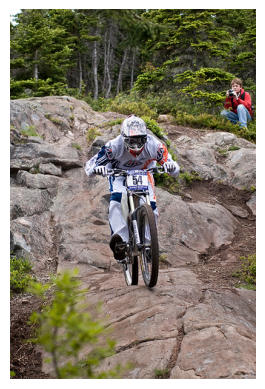

man on motorcycle wheelie through the forest
1/1 [==============================] - 0s 22ms/step


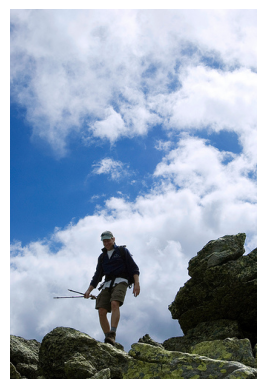

man in red shirt and jeans is jumping off swing
1/1 [==============================] - 0s 20ms/step


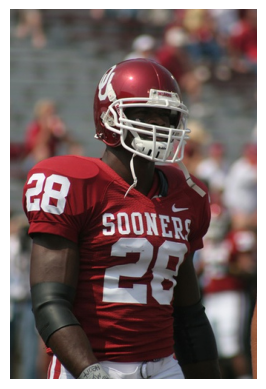

football player in red sooners jersey
1/1 [==============================] - 0s 20ms/step


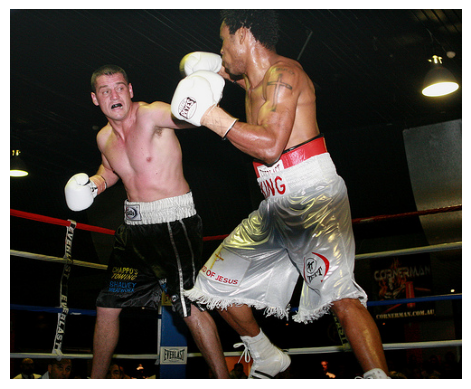

two men boxing in karate match
1/1 [==============================] - 0s 19ms/step


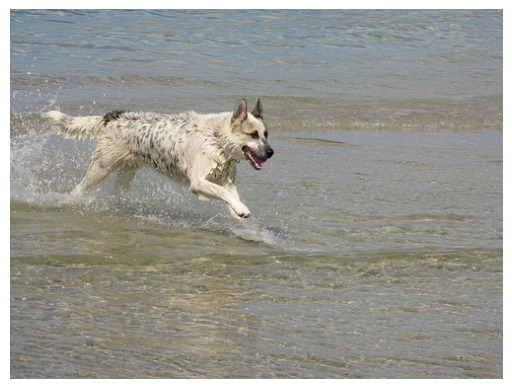

dog running in the surf
1/1 [==============================] - 0s 20ms/step


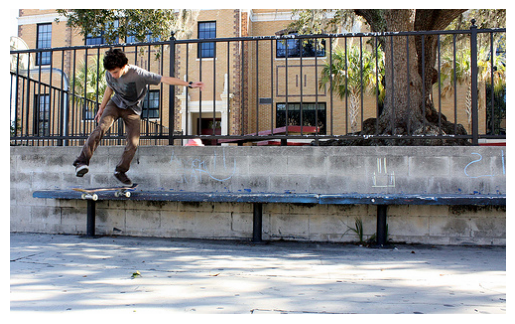

man in red shirt is skateboarding on the side of the steps
1/1 [==============================] - 0s 21ms/step


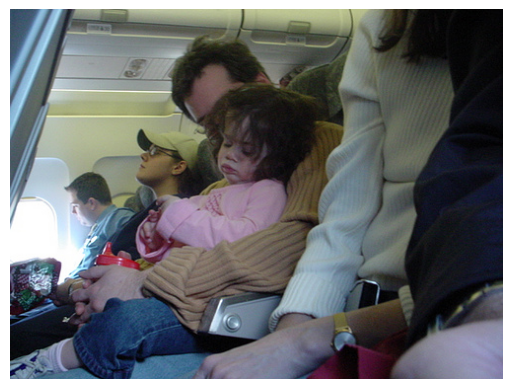

man in blue shirt is helping another man in front of car
1/1 [==============================] - 0s 24ms/step


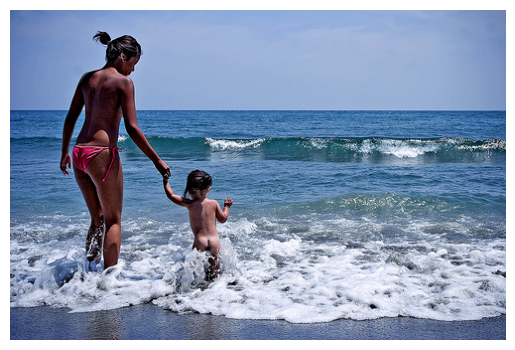

man in wetsuit is surfing on the ocean
1/1 [==============================] - 0s 20ms/step


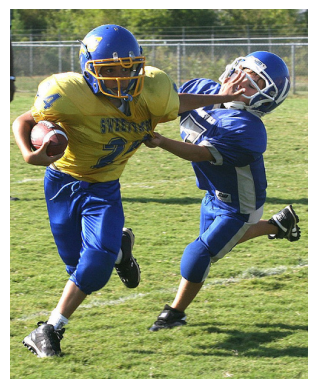

three football players are playing on the field
1/1 [==============================] - 0s 22ms/step


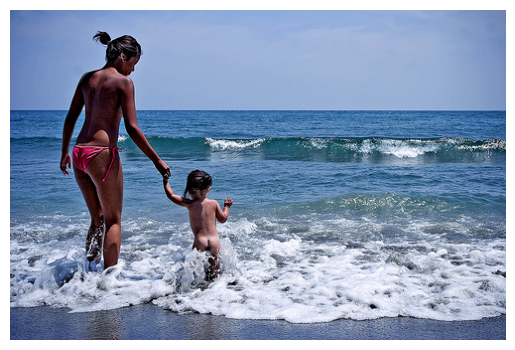

man in wetsuit is surfing on the ocean
1/1 [==============================] - 0s 22ms/step


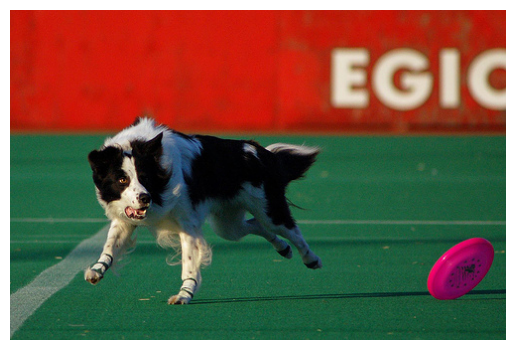

black and white dog is running through an obstacle course
1/1 [==============================] - 0s 22ms/step


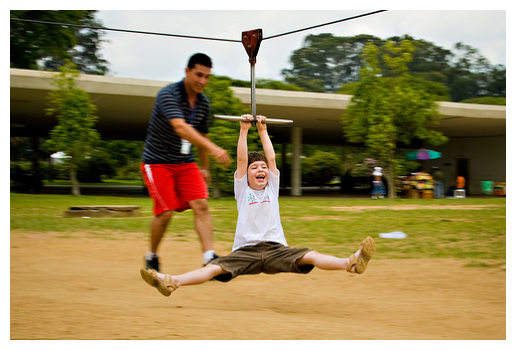

two men in white and one white are playing baseball
1/1 [==============================] - 0s 22ms/step


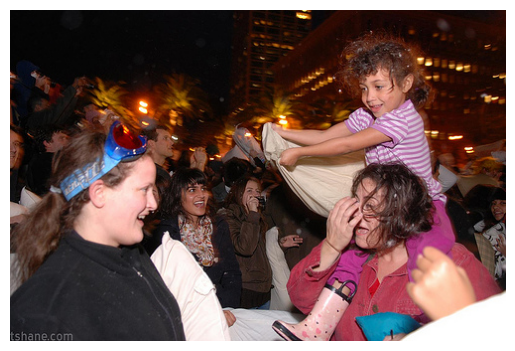

woman in black dress and white hat is standing in front of group of people
1/1 [==============================] - 0s 22ms/step


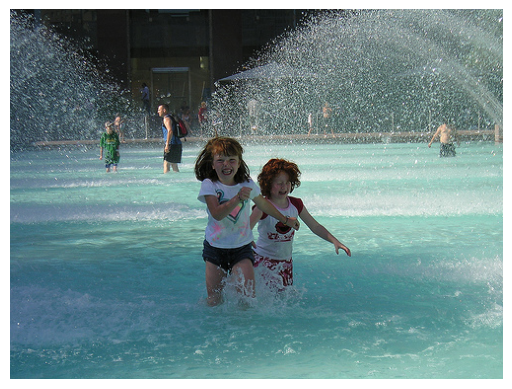

two children are playing in pool
1/1 [==============================] - 0s 23ms/step


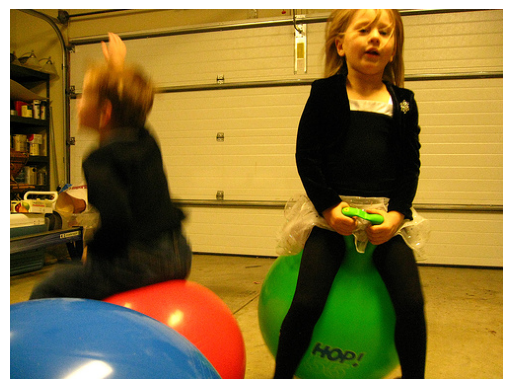

two girls are sitting on the floor


In [36]:
for i in range(15):
    idx = np.random.randint(0, 1000)
    test_imgs = list(encoding_test.keys())
    test_img = test_imgs[idx]
    photo = encoding_test[test_img].reshape((1, 2048))
    img = plt.imread(images_path + test_img + '.jpg')
    caption = predict_caption(photo, max_len, word_2_idx, idx_2_word)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(caption)

# **Evaluation of Captions using BLEU Scores**

In [ ]:
%%capture

from nltk.translate.bleu_score import corpus_bleu

def evaluate_model():
    actual, predicted = list(), list()
    k = 0
    for key, desc_list in img_descriptions.items():
        if encoding_train.get(key) is None:
          continue;
        photo = encoding_train[key].reshape((1, 2048))
        predicted_caption = predict_caption(photo, max_len, word_2_idx, idx_2_word)
        actual_caption = [d.split() for d in desc_list]
        actual.append(actual_caption)
        predicted.append(predicted_caption.split())
        k += 1
        print(k, end=' ')
        if k == 1000:
          break

    bleu_scores = {
        'BLEU-1': corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)),
        'BLEU-2': corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)),
        'BLEU-3': corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)),
        'BLEU-4': corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    }

    return bleu_scores
  
bleu_scores = evaluate_model()
print(bleu_scores)